### FastAPI Course

FastAPI is a modern, fast (high-performance), web framework for building APIs with Python 3.7+ based on standard Python type hints. It's built on top of `Starlette` for the web parts and `Pydantic` for the data parts.


When we isntall dependencies needed for FastAPI, it installs the following libraries:
- `PyDantic`: data valdiation 
- `Starlette`: asynchronous Python library for FastAPI
- `Uvicorn`: deploys web server on local machine and process queries

### How to Run FastAPI App?
To run FastAPI app we need to run the following command:
- `uvicorn <fast_api_main_file>:app --reload`
    - `app`: приложение, `app = FastAPI()`
    - `reload` для автоматической перезагрузки при внесении изменений

FastAPI automatically generates doc (`Swagger`). To access doc, run: `/docs`. Docs has the following structure:

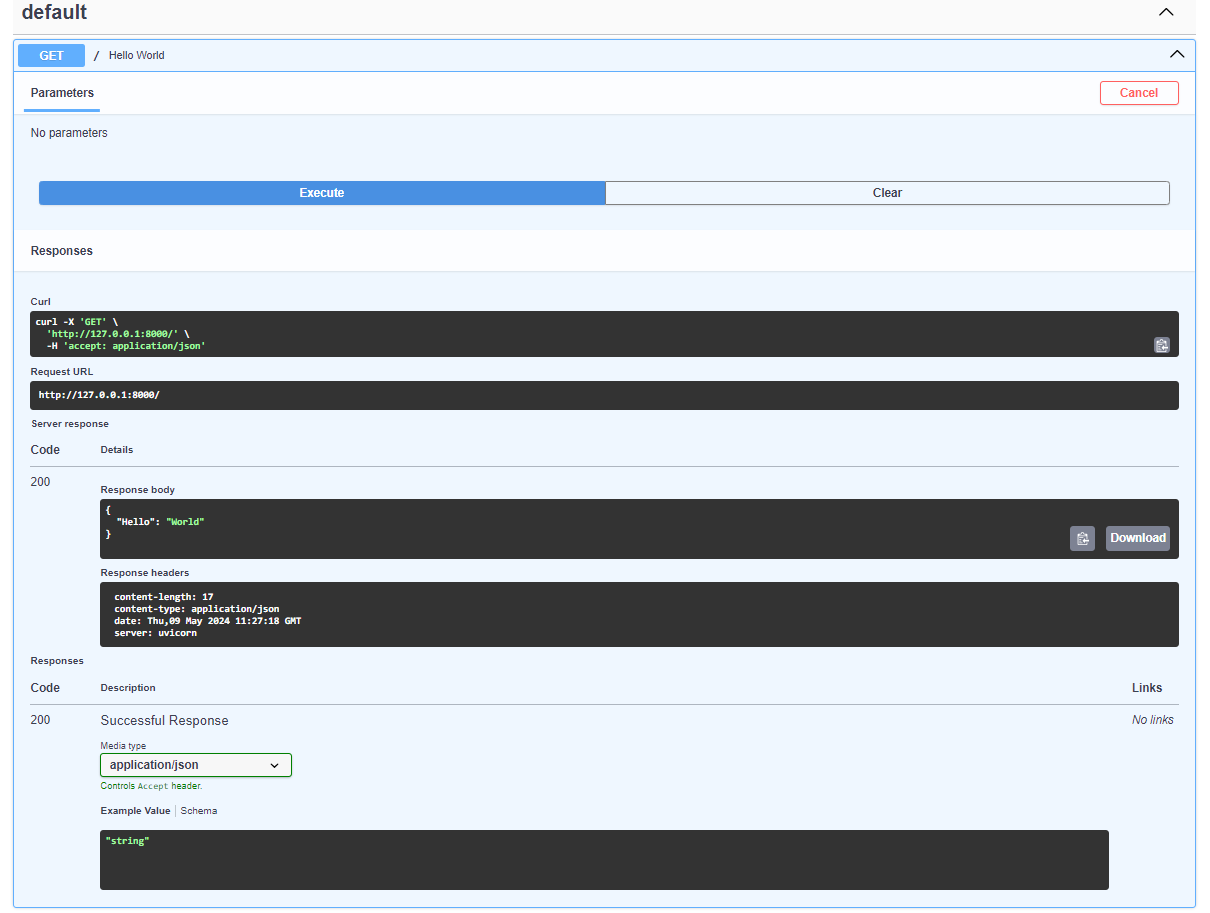

- `Parameters`: parameters of a calling function
- `Responses`: server response with codes (e.g. 200, 404, ...)

There is another part of documentation that can be checked, use `/redoc` (similar to `/docs`)

### Endpoints and URL Parameters
In FastAPI, endpoints are created using functions decorated with specific HTTP method decorators (@app.get, @app.post, @app.put, @app.delete, etc.) to define the operation they handle and the URL they respond to. URL parameters in FastAPI are defined by including variables directly in the URL path. These variables are then extracted and passed as arguments to the endpoint function.

In [ ]:
users = [
    {"id": 1, "role": "admin", "name": "Vlad"},
    {"id": 2, "role": "investor", "name": "John"},
    {"id": 3, "role": "trader", "name": "Alice"},
]

@app.get("/users/{user_id}")
def get_users(user_id: int):
    return [
        user for user in users if user["id"] == user_id
    ]

In this example:

- We define an endpoint using the `@app.get` decorator, specifying the URL path `/users/{user_id}`, where `{user_id}` is a URL parameter.
- The `get_users` function takes an argument `user_id`, which corresponds to the URL parameter.
- When a `GET` request is made to a URL like `/users/1`, FastAPI automatically extracts the value 1 from the URL and passes it to the `item_id` parameter of the `get_users` function.
- **Type of an argument in a function must match with type in selecting element** (e.g. `user_id: int -> "id": 1`)

### Limit and Offset
The limit and offset parameters are commonly used in database queries to control pagination of results.

- `Limit`: Specifies the maximum number of records to retrieve in a single query. For example, if you have a list of items and you set the limit to 10, the query will return at most 10 items.
- `Offset`: Specifies the number of records to skip before starting to return results. For example, if you have a list of items sorted by creation date and you set the offset to 10, the query will start returning items from the 11th item onwards, effectively skipping the first 10 items.

Together, these parameters enable paginated retrieval of large datasets. In a web application pagination allows users to navigate through multiple pages of search results without loading all results at once, which could be inefficient and slow.

In [ ]:
trades = [
    {"id": 1, "user_id": 1, "currency": "BTC", "side": "buy", "price": 123, "amount": 2.12},
    {"id": 2, "user_id": 1, "currency": "BTC", "side": "sell", "price": 125, "amount": 2.12},
]

@app.get("/trades/")
def get_trades(limit: int = 1, offset: int = 0):
    return trades[offset:][:limit]

**Important**
- Pay attention at type of parameters, can be:
    - `query`: Query related
    - `path`: URL related

- Returning parameters are automatically converted into JSON according to REST standards.

For the code above endpoint will look like: `?limit=1&offset=1`

In [ ]:
@app.put("/users/{user_id}")
def change_user_name(user_id: int, new_name: str):
    current_user = list(filter(lambda user: user["id"] == user_id, users))[0]
    current_user["name"] = new_name
    return {"status": 200, "data": current_user}

### Data Validation using PyDantic
Pydantic is a data validation and settings management library in `Python` that's heavily used in `FastAPI` for **request and response validation.** It allows you to define data schemas using Python classes with type hints, making it easy to validate and serialize/deserialize data.

In FastAPI, Pydantic is used for:

- `Request and Response Validation`: FastAPI uses Pydantic models to automatically validate request bodies (JSON payloads) and query parameters based on their type annotations. If the incoming data doesn't match the specified schema, FastAPI returns a validation error response automatically.

- `Automatic Documentation Generation`: FastAPI generates API documentation (both OpenAPI and Swagger UI) **based on Pydantic models**, providing details about the expected request and response payloads, their data types, and any validation constraints.

- `Data Serialization and Deserialization`: Pydantic models are used to serialize Python objects into JSON data for responses and deserialize JSON data into Python objects for request bodies.


Each object has its own data model that descriges that object. For example, data mode *user*, can describe user (age, name, user_name, password, etc.). To ensure that these paramters are aligned everywhere we need to create a model once and then only tell that certain objects must follow that data model rules. This is how FastAPI can validate requests and responses.

In [ ]:
class Trade(BaseModel):
    """
    PyData data model for trades.
    """
    id: int
    user_id: int
    currency: str
    side: str
    price: float = Field(ge=0)
    amount: float = Field(ge=0)


@app.post("/trades")
def add_trades(trades_data: List[Trade]):
    trades.extend(trades_data)
    return {"status": 200, "data": trades}

In [ ]:
# data validation for backend (when we response)
class User(BaseModel):
    id: int
    role: str
    name: str


@app.get("/users/{user_id}", response_model=List[User])
def get_users(user_id: int):
    return [
        user for user in users if user["id"] == user_id
    ]

If an error occurs, client will not see the exact error name -> because of security measure.

In [ ]:
# we can create custom data fileds for validation, for example:
class DegreeName(Enum):
    newbiew = 'newbiew'
    expert = 'expert'


class Degree(BaseModel):
    id: int
    created_at: datetime
    name: DegreeName


class User(BaseModel):
    id: int
    role: str
    name: str
    degree: Optional[List[Degree]] = None

### Data Basese and Migreation / Alembic
Database migration refers to the process of managing **changes to a database schema over time in a systematic and controlled manner.** These changes could involve creating new tables, modifying existing tables, adding or altering columns, creating indexes, and so on. Database migration ensures that as your application evolves, the underlying database structure can be updated accordingly without losing any data or disrupting the operation of your application. This is more or less similar to Git but instead of code we save data base state.

**Key aspects of database migration include:**

- `Version Control`: Just like you version control your application code, database migrations should also be version controlled. Each migration script represents a discrete set of changes to the database schema and should be stored in version control alongside your application code. This enables developers to track changes, collaborate effectively, and revert changes if needed.

- `Reproducibility`: Migrations should be designed to be reproducible, meaning that they can be applied to **any instance of the database**, regardless of its current state. This ensures consistency across development, testing, and production environments.

- `Forward and Backward Compatibility`: Migrations should be designed to be both forward and backward compatible. Forward compatibility ensures that new versions of the application can run on older versions of the database schema, while backward compatibility ensures that older versions of the application can run on newer versions of the database schema.

- `Data Integrity`: Migrations should be designed to preserve data integrity during schema changes. This involves performing data transformations, data migrations, and ensuring that no data is lost or corrupted during the migration process.

**Database Migration Tools**

- `Alembic`: A lightweight database migration tool for `SQLAlchemy`, a popular SQL toolkit and Object-Relational Mapping (ORM) library for Python.

- `Flyway`: A database migration tool that focuses on simplicity and convention over configuration. It supports SQL-based migrations and integrates with various database systems.

- `Liquibase`: A cross-platform database schema change management tool that supports XML, YAML, and SQL as migration formats. It provides features like rollbacks, tracking, and tagging of changes.

By following best practices for database migration, you can ensure that your database schema evolves alongside your application in a predictable and manageable manner, while maintaining data integrity and consistency.

### How to Enable Database Migrations?
- First, run `alembic init migrations` in project root dir. It will generate
    - `alembic.ini` file: alembic configuration file
    - `migrations` directory: describes info related to migrations

- Redefine, `sqlalchemy.url` in `alembic.ini`:
    - e.g. `postgresql://%(DB_USER)s:%(DB_PASSWORD)s@%(DB_PORT)s/%(DB_NAME)s`
    - It will tell alembic what DB to use

- Pass credentials into `alembic.ini`:
    - Create `.env` file with credentials needed
    - Create `config.py` that collects *env variables*

- Redefine `config` variable in `migrations/env.py`

- Initialize migration by running command in project root dir:
    - `alembic revision --autogenerate -m "Database creation"`
    - Once migration is initialized, it creates table in database called `alembic_version`

- Create migration:
    - `alembic upgrade <version_hash>`
    - <version_hash> can be found in `migrations/versions`

**Important**
- It's recommended to rename migration versions in the following way:
    - add date to the file name, e.g. `11_05_24_813424614ce1_database_creation.py`

### User Registration and Authentication
- Copy user logic [from here](https://fastapi-users.github.io/fastapi-users/10.0/configuration/databases/sqlalchemy/)
- Make sure that attributes from class are matched with attributes in DB table!
- Use `Depends` function in `get_user_db` function. This function is responsible for injection dependency
- Define `cookies` [from here](https://fastapi-users.github.io/fastapi-users/10.0/configuration/authentication/transports/cookie/) and define logic in `auth.py`
- Define JWT logic [from here](https://fastapi-users.github.io/fastapi-users/10.0/configuration/authentication/strategies/jwt/)
    - `SECRET` responsible for tokens encoding and decoding. **Must be stored away** and secured!
- Create `UserManager` [from here](https://fastapi-users.github.io/fastapi-users/10.0/configuration/user-manager/)
- Create `Schemas` [from here](https://fastapi-users.github.io/fastapi-users/10.0/configuration/schemas/)
- Create endpoints
    - authentication router [from here](https://fastapi-users.github.io/fastapi-users/10.0/configuration/routers/auth/)
    - registration router [from here](https://fastapi-users.github.io/fastapi-users/10.0/configuration/routers/register/)
    - authorized router [from here](https://fastapi-users.github.io/fastapi-users/10.0/usage/current-user/)

Once, everything is correctly defined, we will get:

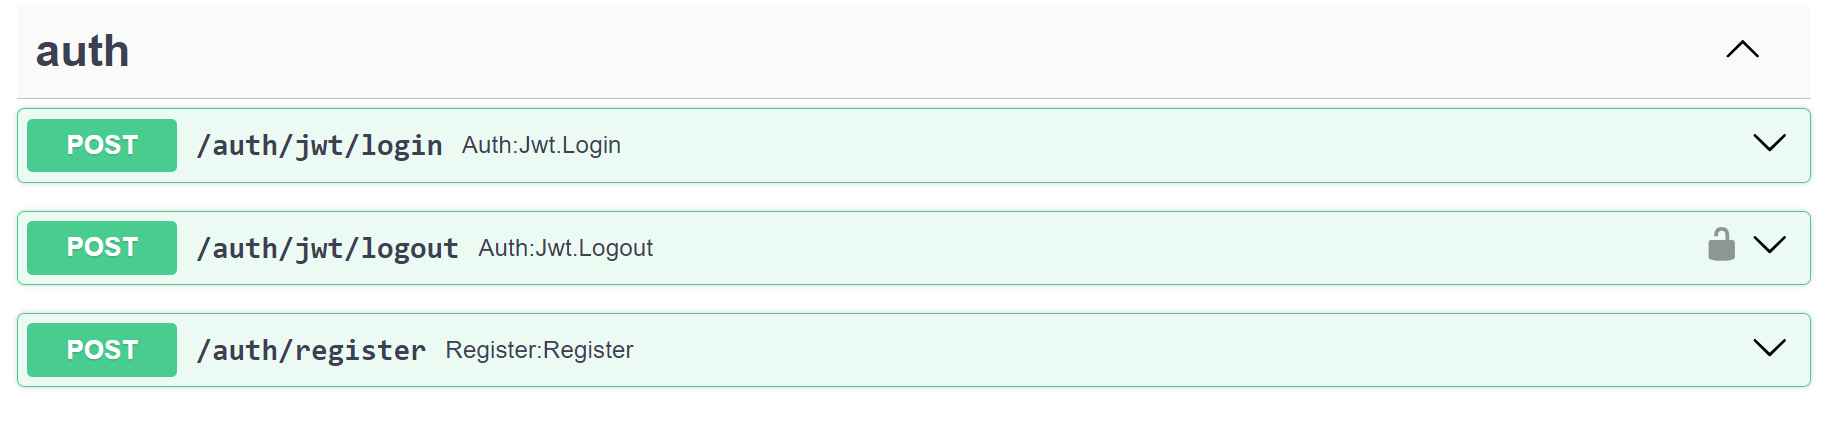

**Important**

Before new user creation/registration we need to insert data into intial DB. Especially in table called `role`:

```
INSERT INTO role VALEUS
    (1, 'user', null),
    (2, 'admin', null);
```

### Routers and Files Structure
- Each new service must have its own directory
- `SQLAlchemy.Metadata` variable acumulates information about created tables:
    - `Alembic` can see what is inside those metadata variables and tracks the difference once there are changes. Those changes represented as revisions.

### Routers
Routers might be defined in two ways:
- Using decorator in `main.py`. Better use when our application is simple
- Using `app.include` in `main.py`. Used when app is complicated. In this case each service has its own `router.py` file.

Router has two main parameters:
- `prefix`: defines final endpoint
- `tags`: describes endpoints group (e.g. 'authentication group', 'registration group', ...)

### How to communicate with Database in FastAPI?
There is no rule for it. Any known method can be applied. However, we need to take into account security mesures! The main problem is SQL Injection! For example, if we have parametrized query where we take user_id from a user. Then any user could just pass `100; DROP TABLE <table_name>` or `100; SELECT * FROM ...`.

One well-know secure method is to use `SQLAlchemy`


### Database Transactions
Operations in relational databases usually done via transactions that provide usefule properties. For example, automcity -> all operations are unite. There is no possibility to split. For example, I made a table update. In this case it is impossible that data is saved and logs not or vice-versa. If something fails, everything fails! 

That's why we have transactions in relational databases and `.commit()` method that finishes the transaction.

### Exceptions Handling 
Different errors or exceptions may happen  during service working in production environment. These exceptions may belong to different entities:
- Server Errors: all exceptions that may happen on server side
- Client Errors: all exceptions that may happen on client side

To handle exceptions properly, use: `HTTPException` that may have the following format:

In [ ]:
def some_function():
    raise HTTTException(status_code=500, detail="Item not found")

def some_function():
    raise HTTTException(status_code=500, detail={
        "status": "error",
        "data": None,
        "details": None,
    })

### Caching with Redis
Redis is an open-source, in-memory data structure store that is used as a database, cache, and message broker. It supports various data structures such as strings, hashes, lists, sets, and sorted sets, and provides atomic operations on these data types. Redis is often used for caching frequently accessed data, real-time analytics, message brokering, job queuing, and more.

It's known for its high performance, scalability, and versatility, making it a popular choice for building fast, scalable applications.

To use caching in FastAPI, we need a library called [FastAPI Cache](https://github.com/long2ice/fastapi-cache)

### Why do we Need Caching?
Caching is essential for several reasons:

- `Performance Improvement`: Caching allows frequently accessed data to be stored closer to the application, reducing the latency involved in retrieving the data from its original source, such as a database or an external API. This results in faster response times and better user experience.

- `Scalability`: By caching frequently accessed data, you can reduce the load on backend systems, such as databases, which can help improve overall system scalability. Caching can absorb spikes in traffic and reduce the strain on backend resources during peak usage periods.

- `Cost Reduction`: Caching can help reduce operational costs associated with accessing and processing data from expensive resources like databases or external APIs. By caching data, you can minimize the number of requests made to these resources, potentially reducing associated costs.

- `Redundancy`: Caching provides redundancy by storing copies of data in memory or on disk. This can help ensure data availability and reliability, even if the primary data source becomes temporarily unavailable.

- `Load Balancing`: Caching can be used in conjunction with load balancing techniques to distribute traffic more evenly across multiple servers or instances. By caching data at different layers of the application stack, you can reduce the load on individual servers and improve overall system performance and reliability.

Overall, caching is a powerful technique for optimizing performance, improving scalability, reducing costs, and enhancing the reliability of applications and systems.

### FastAPI Start Up and Shut Down 
FastAPI has tow main functions that responsible for FastAPI app start up and shutting down (define logic).

Caching happens using the following unique combination parameters: 
- `function name`
- `function parameters`

If these parameters change, caching is done again!

### Background Tasks using Celery and Flower
Celery and Flower are two popular tools used in Python for managing background tasks, especially in web applications.

- `Celery`: Celery is a distributed task queue library for Python that allows you to run background tasks asynchronously or scheduled at a later time. It's often used for tasks that are time-consuming, such as sending emails, processing large datasets, or interacting with external APIs. Celery supports various message brokers like RabbitMQ, Redis, or even a database, which are used to send and receive messages between the application and the Celery workers.

- `Flower`: Flower is a real-time web-based monitoring tool for Celery. It provides a dashboard that allows you to monitor the status and progress of your Celery tasks, view worker statistics, and inspect task history. Flower is particularly useful for debugging and optimizing Celery-based applications, as it provides insights into task execution times, worker utilization, and overall system performance.

Together, Celery and Flower form a powerful combination for managing background tasks in Python applications, providing asynchronous task execution, scalability, and monitoring capabilities to help you build robust and efficient systems.

**How to run Celery Worker?**
- `celery -A <path_to_task_file>:celery worker --loglevel=INFO`

**How to run Celery Tasks Dashboard?**
- `celery -A <path_to_task_file>:celery flower`

Here `Redis` is used as broker (accumulates tasks for workers)


### API Testing using PyTest
In FastAPI there are several ways of testing our API:
- `TestingClient`: synchronos testing
- `Async Tests`: asynchronos tests.

For testing we need:
- Testing Client to test the API
- Testing Database


**Testing Structure**

Tests usually located in root directory near app folder but not inside app! Once main folder for tests has been defined we can define the followwing files:
- `conftest.py`: the main configuration file for PyTest-
- `test_<service_name>:` test that tests a certain service. Insie that file we have list of tests to run

### FastAPI CORS and Middleware
Let's assume that we have backend app and frontend app, we would like to unite them into a single final app.

**What are CORS?**
CORS stands for *Cross-Origin Resource Sharing*. It's a mechanism that allows web servers to specify which origins are permitted to access the resources on a server across different domains. This is an important security feature implemented by web browsers to prevent malicious scripts from accessing resources hosted on different domains.

In the context of FastAPI, CORS can be configured to allow or restrict cross-origin requests to your API endpoints. FastAPI provides built-in support for handling CORS through its `CORSMiddleware`. By default, FastAPI CORS middleware allows requests from all origins, but you can configure it to only allow requests from specific origins, methods, headers, etc., depending on your application's requirements.

### Websockets
Websockets are used when we have lots of data that must be sent to client very often (usually in real time). If any changes happen on bacend side, client side should see these changes as well (e.g. live chat, trade apps).